# EDA 


## Dataset description
The dataset used here is made for fake news detection AI research, 
composed of 72,134 news articles, where 35,028 of them are real and 37,106 are fake news.
To reduce overfitting by topic-bias between real and fake, 
the researcher merged four popular news data sets (i.e., Kaggle,
McIntire, Reuters, and BuzzFeed Political) and prepared a
more generic data set [link](https://ieeexplore.ieee.org/document/9395133).

The field compose of news title (title), content (text), and label for real (0) and fake (1) news.

## About this file
This is the first notebook session to take a look at raw data.
Before preprocess text, we will explore raw text data to find items to consider for cleaning and preprocessing.
For each EDA item, I summarized observation and preprocessing item for the next step (in another file).

In [1]:
import time

from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import regex as re

import spacy

from nltk.tokenize import sent_tokenize
from nltk import ngrams


pd.options.display.max_colwidth = 200

# Data format

In [2]:
df = pd.read_csv('Data/WELFake_Dataset.csv')

# Duplication is wrong here
df.drop_duplicates()
print(df.info())

# Label count
print(df.label.value_counts()) # number of real (0) and fake (1) news

display(df[df.label==0].head(5))
display(df[df.label==1].head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB
None
1    37106
0    35028
Name: label, dtype: int64


,Unnamed: 0,title,text,label
3,3,"Bobby Jindal, raised Hindu, uses story of Christian conversion to woo evangelicals for potential 2016 bid",A dozen politically active pastors came here for a private dinner Friday night to hear a conversion story unique in the context of presidential politics: how Louisiana Gov. Bobby Jindal traveled f...,0
11,11,"May Brexit offer would hurt, cost EU citizens - EU parliament","BRUSSELS (Reuters) - British Prime Minister Theresa May s offer of settled status for EU residents is flawed and will leave them with fewer rights after Brexit, the European Parliament s Brexit ...",0
12,12,Schumer calls on Trump to appoint official to oversee Puerto Rico relief,"WASHINGTON (Reuters) - Charles Schumer, the top Democrat in the U.S. Senate, called on President Donald Trump on Sunday to name a single official to oversee and coordinate relief efforts in hurric...",0
14,14,No Change Expected for ESPN Political Agenda Despite Huge Subscriber Decline - Breitbart,"As more and more sports fans turn off ESPN to protest the network’s social and political agenda, parent company Disney’s decision to extend current CEO Bob Iger’s contract through 2019 means the...",0
15,15,Billionaire Odebrecht in Brazil scandal released to house arrest,"RIO DE JANEIRO/SAO PAULO (Reuters) - Billionaire Marcelo Odebrecht, the highest-profile executive imprisoned in Brazil s massive graft scandal, was released from jail on Tuesday to continue his se...",0


,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO],No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others o...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE “PEACEFUL” PROTESTERS…In Her Home State Of North Carolina [VIDEO],"Now, most of the demonstrators gathered last night were exercising their constitutional and protected right to peaceful protest in order to raise issues and create change. Loretta Lynch aka Er...",1
4,4,SATAN 2: Russia unvelis an image of its terrifying new ‘SUPERNUKE’ – Western world takes notice,"The RS-28 Sarmat missile, dubbed Satan 2, will replace the SS-18 Flies at 4.3 miles (7km) per sec and with a range of 6,213 miles (10,000km) The weapons are perceived as part of an increasingly ag...",1
5,5,About Time! Christian Group Sues Amazon and SPLC for Designation as Hate Group,"All we can say on this one is it s about time someone sued the Southern Poverty Law Center!On Tuesday, D. James Kennedy Ministries (DJKM) filed a lawsuit against the Southern Poverty Law Center (S...",1


### Observation
- Metadata
    - Balanced dataset.
    - Some null entries.
    - Unused 'Unnamed: 0' column
    - 'label' column can be a category type to reduce memory size.
- Title
    - Real news title is **informative and concise**.
    - Fake news title sounds **gossip** and contains **clickbait**.
    - Fake news title has extra **upper cases**, probably to catch attention
    - Some real news text starts with source, **"Location (Reuters)"**. This part should be removed in order not to introduce bias when genalize this model out of Reuter news.
    - Title news use more **special characters**.

In [3]:
# Check NaN entries
df[df.isna().any(axis=1)]

,Unnamed: 0,title,text,label
1,1,NaN,Did they post their votes for Hillary already?,1
43,43,NaN,"True. Hillary needs a distraction and what better than a real ""wag the dog"" with Russia.",1
162,162,NaN,All eyes on Electoral delegates. The People know where they live!,1
185,185,NaN,Cool,1
269,269,NaN,A leading US senator: US Supporting War in Syria\nA leading US senator said the war in Syria would have been over by now if the US had put an end to its intervention when Russia entered the war-ra...,1
...,...,...,...,...
71484,71484,NaN,Another Arab supremacist masturbation fantasy. The world map was re-shaped after the fall of the Ottoman empire almost 100 years ago. And the Palestine Arabs refused several very good offers since...,1
71521,71521,NaN,I'm sure they drastically changed accounting methods because things are going better than ever.,1
71540,71540,NaN,"It's easy to imagine Obama or Kerry pissing him off, but I haven't heard specifically what the US did to set him off.",1
71570,71570,NaN,Ever since the powers to be assassinated JFK American society and foreign policy has been getting more and more barbaric and more and more arrogant and self serving. The next president just might ...,1


In [4]:
# Drop data we don't use 
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace=True) # it seems not worthy to keep

# Reduce memory size
df = df.astype({'label': 'category'})

# Check examples

In [5]:
print('\nReal title example =========== \n',df[df.label==0].sample(20, random_state=40).title.to_numpy())
print('\nFake title example =========== \n',df[df.label==1].sample(20, random_state=40).title.to_numpy())

print('\nReal text example =========== \n',df[df.label==0].sample(2, random_state=30).text.to_numpy())
print('\nFake text example =========== \n',df[df.label==1].sample(2, random_state=30).text.to_numpy())


Real title example =========== 
 ['Trump picks financier Scaramucci to head White House communications: official'
 "China's RYB Education fires head of Beijing kindergarten embroiled in abuse scandal"
 'Pet Pigs of New York: Illegal, Embattled, Beloved - The New York Times'
 'EPA Administrator Scott Pruitt at CPAC: After 8 Years We’ll Have Better Air, Better Water - Breitbart'
 'Trump, in Interview, Moderates Views but Defies Conventions - The New York Times'
 'South Korea, U.S., Japan kick off two-day missile tracking drill: South Korea military'
 'Teen Jackie Evancho first singer confirmed for Trump inauguration'
 "NY mayor criticizes Trump's closing public atrium for campaign events"
 'U.S. House Speaker Ryan offers election-year security agenda'
 'Anti-Assad nations say no to Syria reconstruction until political process on track'
 'May to pitch on Brexit at EU summit dinner'
 'Venezuela political talks end without deal, new meeting planned Dec. 15'
 'Irma evacuees find full hotels

### Observation

- Should remove **newspaper names** (e.g.  - The New York Times) in the **title**.
- Fake news sounds **redundunt**.
- Real and fake news looks different in **grammar structure**, but it is hard to describe how different they are.

# Text length

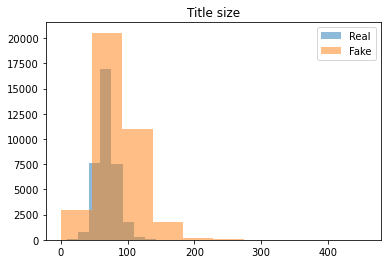

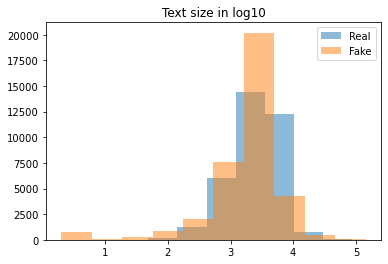

In [6]:
plt.hist(df[df.label==0].title.str.len(), alpha=0.5)
plt.hist(df[df.label==1].title.str.len(), alpha=0.5)
plt.title("Title size")

plt.legend(['Real','Fake']) 
plt.show()

plt.hist(np.log10(df[df.label==0].text.str.len()+1), alpha=0.5)
plt.hist(np.log10(df[df.label==1].text.str.len()+1), alpha=0.5)
plt.title("Text size in log10")

plt.legend(['Real','Fake']) 
plt.show()

In [7]:
# Check why some are very long -> didn't find anything weird just by reading samples
#df[(df.text.str.len()>50000)&(df.label==0)].sample(3).text.tolist() 
#df[(df.text.str.len()>50000)&(df.label==1)].sample(3).text.tolist()

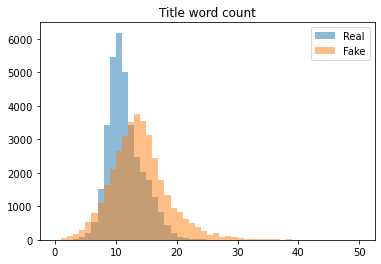

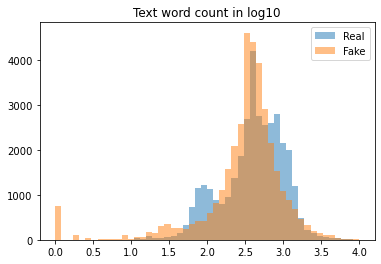

In [8]:
df['title_count'] = df.title.str.split().str.len()
df['text_count'] = df.text.str.split().str.len()

plt.hist(df[df.label==0].title_count, alpha=0.5, range=(0,50), bins=50)
plt.hist(df[df.label==1].title_count, alpha=0.5, range=(0,50), bins=50)
plt.title("Title word count")

plt.legend(['Real','Fake']) 
plt.show()

plt.hist(np.log10(df[df.label==0].text_count+1), alpha=0.5, range=(0,4), bins=50)
plt.hist(np.log10(df[df.label==1].text_count+1), alpha=0.5, range=(0,4), bins=50)
plt.title("Text word count in log10")

plt.legend(['Real','Fake']) 
plt.show()

### Observation
- As notices with raw data examples, fake news has **longer title**.
- Real news contents are written in **either around 100 words or 400 words**, wheras fake news has larger spectrum.
- Some fake news has **few or zero words** in titles and text. Let's take a look what that means.

In [9]:
real_few_title = df[(df.label==0)&(df.title_count<4)]
fake_few_title = df[(df.label==1)&(df.title_count<4)]

real_few_text = df[(df.label==0)&(df.text_count<30)]
fake_few_text = df[(df.label==1)&(df.text_count<30)]

In [10]:
print('News with title < 3 words, real:',len(real_few_title))
print('News with title < 3 words, fake:',len(fake_few_title))
print('News with text < 6 words, real:',len(real_few_text))
print('News with text < 6 words, fake:',len(fake_few_text))

News with title < 3 words, real: 23
News with title < 3 words, fake: 303
News with text < 6 words, real: 259
News with text < 6 words, fake: 1994


In [11]:
print('Empty title examples, real news\n')
display(real_few_title)

print('Empty title examples, fake news\n')
display(fake_few_title.sample(30, random_state=20))

print('Empty text examples, real news\n')
display(real_few_text.sample(30, random_state=20))

print('Empty text examples, fake news\n')
display(fake_few_text.sample(30, random_state=20))

Empty title examples, real news



,title,text,label,title_count,text_count
3653,Gaming Obamacare,"Killing Obama administration rules, dismantling Obamacare and pushing through tax reform are on the early to-do list.",0,2,17
3913,The Collectivist Election,"When Henry Adams wrote in the early 20th century that ""politics, as a practice whatever its professions, had always been the systematic organization of hatreds,"" there was ample reason to take him...",0,3,1226
4149,Trump's women problem,"(CNN) The thing about women, Donald J. Trump once wrote, is that they ""have one of the great acts of all time.""\n\n""The smart ones act very feminine and needy, but inside they are real killers,"" h...",0,3,2389
6033,‘Are We Next?’,"When the news broke that our French colleagues had been killed, a deep feeling of pain overwhelmed my newsroom—and an immediate feeling of fear. All of a sudden it seemed possible that we might be...",0,3,993
6471,Bernie's California endgame,"The election in 232 photos, 43 numbers and 131 quotes, from the two candidates at the center of it all.",0,3,20
9603,"poll: Alarm, anxiety","Republican Pat McCrory is trailing in a tight race, but his campaign is challenging votes.",0,3,15
9775,Cruz's immigration gambit,A verdict in 2017 could have sweeping consequences for tech startups.,0,3,11
10350,Obama veers left,"On Day 13, a video message and a meeting with media executives—but still no press conference, protective pool",0,3,18
13700,Boehner's big week,Top Dems want White House to call off Part B demo — The next cancer drug shortage,0,3,17
15981,Cruz's immigration gambit,"During the campaign, Trump had threatened to impose a large tariff to keep the jobs in the United States.",0,3,19


Empty title examples, fake news



,title,text,label,title_count,text_count
52702,https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/,https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/,1,1,1
28810,Tom Hayden's Haunting,"License DMCA \nAs an old SDS-er, I found it hard to see Tom Hayden go. However meandering his path, he was at the heart of radical history in the 60s, an erstwhile companion, if not always a comra...",1,3,755
49546,Newsticker (973),"+++ Zu Wild geschaukelt: Spielendes Kind stürzt in benachbartes Hirschgehege +++ +++ Miros Love: Klose stellt neue Freundin vor +++ +++ Einmal drin, alles hin: Elefant kauft bei real,- +++ +++ Vie...",1,2,94
18763,Re: - WikiLeaks,How to contact WikiLeaks? What is Tor? Tips for Sources After Submitting \nThis key's fingerprint is A04C 5E09 ED02 B328 03EB 6116 93ED 732E 9231 8DBA BEGIN PGP PUBLIC KEY BLOCK mQQNBFUoCGgBIADFLp...,1,3,125
7621,Rule or Ruin,"Here's something interesting from The Unz Review... Recipient Name => Pat Buchanan not only read these books, he wrote them. Credit: VDare.com. \nIf only Donald Trump hadn’t been such a crazy, thi...",1,3,1361
29364,“Weinergate”,"https://www.lewrockwell.com/lrc-blog/weinergate/ \nThe name given to the latest Clinton Crime Family brouhaha by a Baltimore radio talk show host. 6:46 am on October 31, 2016",1,1,24
38051,:,"We the People Against Tyranny: Seven Principles for Free Government\nBy John W. Whitehead\nAs I look at America today, I am not afraid to say that I am afraid.Former presidential advisor Ber...",1,1,1656
50807,Re: Vladimir Putin,"« Reply #328 on: August 24, 2015, 07:35:18 PM » Didn't really think Putin was falsely fagging.. Oh well. The Assassination of Russia - FSB false flag bombings of 1999 https://youtu.be/y9cRoXgawVA ...",1,3,1417
48405,Consortiumnews,"VIPS Memos November 13, 2016 \nDonald Trump’s win shook up the System but the empire is already striking back as the same-ole powers-that-be seek to “guide” Trump back to establishment-friendly an...",1,1,1674
11888,Links 11/12/16,"What Does Trump’s Victory Mean For NATO? NPR. Charles flags the close, which is an unusually pointed admission of the basis of our imperialist project. \nBrexit \nTurkey is swiftly heading towards...",1,2,647


Empty text examples, real news



,title,text,label,title_count,text_count
55787,Congress clears $1.8 trillion tax and spending bills,"“You can’t be in a rush to do the wrong thing, either,” she said. “This is serious stuff.”",0,8,18
20387,How Ryan decided to ditch Trump,"""One should not insist on nailing [Trump] into positions that he had taken in the campaign,"" he said.",0,6,18
30427,Pakistani Nationals Arrested for Holding Migrants Hostage,ROME (AP) — Police in Greece have arrested three Pakistani nationals for holding hostage 16 migrants without authorization to be in the country and demanding money for their release.,0,7,29
38563,Clinton ekes out win in Iowa against Sanders,"Killing Obama administration rules, dismantling Obamacare and pushing through tax reform are on the early to-do list.",0,8,17
43281,Immigration crackdown splits GOP,"Notable names include Ray Washburne (Commerce), a Dallas-based investor, is reported to be under consideration to lead the department.",0,4,19
8186,Russia's Putin says we will be able to solve the North Korea crisis by diplomatic means,"VLADIVOSTOK, Russia (Reuters) - Russian President Vladimir Putin said on Thursday that the crisis around North Korea could be resolved by diplomatic means.",0,16,23
26051,Reid plotting to stay in power,Ohio Democrat Tim Ryan does a lot of media but only has 2 public supporters,0,6,15
3362,GOP Candidates Say Paris Attacks Highlight U.S. Leadership Failure,"GOP presidential candidates called for prayers for victims of the terrorist attacks in Paris and a swift response from the U.S., while criticizing President Barack Obama‘s foreign policy.",0,9,28
4751,Lockheed Martin wins $1.6 billion U.S. defense contract: Pentagon,"WASHINGTON (Reuters) - Lockheed Martin Corp was awarded a $1.6 billion order-dependent contract for the Counter Fire Target Acquisition Radar System, the Pentagon said on Thursday.",0,9,26
66127,Hillary Clinton's first test,"“We obviously spoke about my passion and his passion, which [is] veterans and veterans issues,” he said.",0,4,17


Empty text examples, fake news



,title,text,label,title_count,text_count
33299,World War 3 Begins! Trump Elected,I Dont Actualy Like Trump thoif yu like him then your an idiot﻿,1,6,13
15655,UNAIRED Documentary Illuminati Child Abduction Rings Exposed PT 4,Support Us UNAIRED Documentary Illuminati Child Abduction Rings Exposed PT 4,1,9,11
51411,Chart of The Day: Massive Asset Deflation Ahead,Chart of The Day: Massive Asset Deflation Ahead,1,8,8
60727,PELOSI FEEDS LIES TO CBS ANCHORS: Claims That Comey has ‘Spoken Out’ on Trump’s Wiretap Claim,He s created nothing except chaos Delusional Nancy Pelosi,1,16,9
60889,BREAKING: MYSTERIOUS METAL OBJECT Flings Out Of Hillary’s Pant Leg During Apparent Convulsion Or Seizure [Video],,1,16,0
70683,DONALD TRUMP SKIPS MEDIA: Delivers Transition Update Straight To The People [Video],,1,12,0
10416,Who do you think won the CNBC GOP Presidential Debate?,"Please help us determine who real grassroots conservatives think won the CNBC (Communist News By Commies) Debate:// <![CDATA[ (function(w,d,s,i){w.ldAdInit=w.ldAdInit||[];w.ldAdInit.push({slot:816...",1,10,23
29402,WHAT’S WRONG WITH THIS PICTURE? 5 Anti-Trump Activists On Magazine Cover Just Made Us Detest Them Even More,,1,18,0
13416,"Doesn’t Matter WHO Hacked Podesta, If Emails are TRUE","It only takes a few moments to share an article, but the person on the other end who reads it might have his life changed forever Today's Top Stories",1,9,29
8909,https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg,https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg,1,1,1


### Findings
- Very few real news examples have short title or text. Since their formats look ok, I won't exclude them from training.
- **Fake news with very short title or text** have web addresses (or probably sources) as their titles. Either data collection is not properly done or those journals have unusual news article formats. I'll **remove** them from the dataset.

In [12]:
# avoid empty or website address
df = df[(df.label==0)|(df.title.str.split().str.len()>=2)]

# avoid empty or website address AND
# you need at least 5 words to describe who, when, where, what, how (no why for breaking news)
df = df[(df.label==0)|(df.text.str.split().str.len()>=5)]

# Frequent words
Some words are more frequent in real or fake news, because of their purpose (we should utilize those words in classification) or just biased topic (we shouldn't use those words to avoid overfiting).
Let's take a look.

In [13]:
print("Most common words, Real title")
print(Counter(" ".join(df[df.label==0]["title"]).split()).most_common(100))

print("Most common words, Fake title")
print(Counter(" ".join(df[df.label==1]["title"]).split()).most_common(100))

print("Most common words, Real text")
print(Counter(" ".join(df[df.label==0]["text"]).split()).most_common(100))

print("Most common words, Fake text")
print(Counter(" ".join(df[df.label==1]["text"]).split()).most_common(100))



Most common words, Real title
[('to', 11291), ('-', 9039), ('New', 7076), ('The', 7054), ('in', 6876), ('York', 6449), ('Times', 6334), ('Trump', 6320), ('of', 5274), ('on', 4653), ('U.S.', 4284), ('for', 4233), ('says', 3053), ('the', 2651), ('Breitbart', 2397), ('a', 2188), ('and', 2053), ('with', 1773), ('House', 1665), ('as', 1536), ('at', 1536), ('over', 1132), ('after', 1023), ('White', 1021), ('North', 1013), ('Clinton', 997), ('by', 987), ('from', 978), ('Obama', 917), ('Donald', 881), ('Russia', 864), ('Is', 852), ('Senate', 829), ('not', 811), ('will', 759), ('Republican', 742), ('Korea', 737), ("Trump's", 728), ('is', 673), ('China', 656), ('State', 613), ('new', 603), ('bill', 591), ('tax', 590), ('be', 585), ('Iran', 553), ('With', 526), ('U.N.', 511), ('South', 510), ('deal', 505), ('vote', 497), ('EU', 493), ('against', 488), ('In', 481), ('After', 472), ('election', 469), ('talks', 465), ('Trump,', 464), ('Trump’s', 460), ('Republicans', 448), ('court', 445), ('calls', 

### Observation
- Some newspaper names are frequently appear. They should be removed. Examples are:
    - New York Times
    - Breitbart
    - Factbox:
    - Reuters
    
- Fake news have first names in title.
- Fake news have "Video", "Watch" frequently.

## Check potential bias
High classification due to newspaper names are not desired. 
Such word can be character of fake (real) news, or just from topic bias.
Let's take a look.

In [14]:
real = df[df.label==0].sample(1000)
fake = df[df.label==1].sample(1000)

nlp = spacy.load("en_core_web_sm")


def gen_lemma(corpus):
    
    doc = nlp(corpus)
    
    lemma = [token.lemma_ for token in doc if (not token.is_stop) and (token.is_alpha)]
    
    lemma = ' '.join(lemma)
    
    return lemma

real['lemma_title'] = real.title.apply(gen_lemma)
fake['lemma_title'] = fake.title.apply(gen_lemma)
real['lemma_text'] = real.text.apply(gen_lemma)
fake['lemma_text'] = fake.text.apply(gen_lemma)


def gen_ngram(lst):

    uni = []
    bi = []
    tri = []
    
    for corpus in lst:
        words_uni = ngrams(corpus.lower().split(), 1)
        words_bi = ngrams(corpus.lower().split(), 2)
        words_tri = ngrams(corpus.lower().split(), 3)
        

        for word in words_uni:
            uni.append(word)
            
        for word in words_bi:
            bi.append(word)
            
        for word in words_tri:
            tri.append(word)
                        
    return uni, bi, tri

title0 = real.title.tolist()
title1 = fake.title.tolist()
text0 = real.text.tolist()
text1 = fake.text.tolist()
lemma_title0 = real.lemma_title.tolist()
lemma_title1 = fake.lemma_title.tolist()
lemma_text0 = real.lemma_text.tolist()
lemma_text1 = fake.lemma_text.tolist()

ngram_lst = []
ngram_lst.append(gen_ngram(title0))
ngram_lst.append(gen_ngram(title1))
ngram_lst.append(gen_ngram(text0))
ngram_lst.append(gen_ngram(text1))

ngram_lst.append(gen_ngram(lemma_title0))
ngram_lst.append(gen_ngram(lemma_title1))
ngram_lst.append(gen_ngram(lemma_text0))
ngram_lst.append(gen_ngram(lemma_text1))

In [15]:
for i in range(4):
    for j in range(3):

        freq_real = [x[0] for x in Counter(ngram_lst[i*2][j]).most_common(500)]
        freq_fake = [x[0] for x in Counter(ngram_lst[i*2+1][j]).most_common(500)]
        
        only_in_real = []
        for x in freq_real:
            if not x in freq_fake:
                only_in_real.append(x)
                
        only_in_fake = []
        for x in freq_fake:
            if not x in freq_real:
                only_in_fake.append(x)
                
        print('Token only in real: ')
        print(only_in_real)
        
        print('Token only in fake: ')
        print(only_in_fake)

Token only in real: 
[('york',), ('breitbart',), ('north',), ("trump's",), ('korea',), ('border',), ('trump,',), ('senate',), ('congress',), ('u.n.',), ('seeks',), ('china',), ('pm',), ('talks',), ('factbox:',), ('leader',), ('minister',), ('german',), ('climate',), ('brexit',), ('ban',), ('california',), ('healthcare',), ('sources',), ('tillerson',), ('budget',), ('lawmakers',), ('trade',), ('fire',), ('texas',), ('ahead',), ('exclusive:',), ('eu',), ('official',), ('islamic',), ('leaders',), ('coalition',), ('turkey',), ('amid',), ('under',), ('air',), ('saudi',), ('south',), ('ryan',), ('meet',), ('macron',), ('probe',), ('urges',), ('travel',), ('putin',), ('paris',), ('myanmar',), ('speaker',), ('kill',), ('independence',), ('ready',), ('least',), ('aid',), ('briefing',), ('intelligence',), ('france',), ('city',), ('kills',), ('passes',), ('convention',), ('near',), ('protests',), ('protest',), ('seek',), ('japan',), ('ministry',), ('brazil',), ('reform',), ('rules',), ('administr

Token only in real: 
[('”',), ('-',), ('(reuters)',), ('trump’s',), ('tax',), ('“i',), ('ms.',), ('minister',), ('china',), ('week',), ('“we',), ('tuesday',), ('south',), ('border',), ('european',), ('senior',), ('senator',), ('chief',), ('meeting',), ('leaders',), ('friday',), ('islamic',), ('billion',), ('killed',), ('executive',), ('set',), ('companies',), ('leader',), ('forces',), ('early',), ('thursday',), ('wednesday',), ('immigration',), ('reuters',), ('nearly',), ('eu',), ('a.',), ('year,',), ('monday',), ('budget',), ('later',), ('months',), ('expected',), ('company',), ('move',), ('held',), ('groups',), ('barack',), ('five',), ('korea',), ('agency',), ('plans',), ('spokesman',), ('that’s',), ('team',), ('prime',), ('syrian',), ('often',), ('program',), ('head',), ('wall',), ('year.',), ('legislation',), ('union',), ('financial',), ('nations',), ('earlier',), ('began',), ('spending',), ('air',), ('issues',), ('planned',), ('governor',), ('announced',), ('bush',), ('council',),

Token only in real: 
[('washington', '(reuters)', '-'), ('(reuters)', '-', 'the'), ('u.s.', 'president', 'donald'), ('in', 'a', 'statement.'), ('(reuters)', '-', 'u.s.'), ('in', 'a', 'statement'), ('house', 'of', 'representatives'), ('said', 'it', 'was'), ('the', 'u.', 's.'), ('said', 'he', 'had'), ('said', 'in', 'an'), ('the', 'trump', 'administration'), ('the', 'european', 'union'), ('president', 'donald', 'trump’s'), ('the', 'country', 's'), ('(reuters)', '-', 'a'), ('is', 'expected', 'to'), ('he', 'did', 'not'), ('chairman', 'of', 'the'), ('said', 'he', 'would'), ('it', 'was', 'not'), ('the', 'affordable', 'care'), ('the', 'head', 'of'), ('said', 'he', 'was'), ('the', 'house', 'of'), ('follow', 'him', 'on'), ('parts', 'of', 'the'), ('of', 'the', 'house'), ('he', 'said.', 'the'), ('he', 'said', 'he'), ('for', 'more', 'than'), ('he', 'said', 'in'), ('between', 'the', 'two'), ('a', 'spokesman', 'for'), ('said', 'in', 'the'), ('said', 'on', 'tuesday'), ('of', 'the', 'country'), ('to', 

Token only in real: 
[('washington', 'reuters'), ('tell', 'reuters'), ('european', 'union'), ('house', 'representatives'), ('say', 'tuesday'), ('news', 'conference'), ('chief', 'executive'), ('puerto', 'rico'), ('reuters', 'president'), ('say', 'thursday'), ('say', 'wednesday'), ('say', 'friday'), ('tax', 'cut'), ('tax', 'reform'), ('say', 'interview'), ('obama', 'say'), ('say', 'monday'), ('say', 'president'), ('police', 'say'), ('decline', 'comment'), ('tax', 'rate'), ('republican', 'senator'), ('news', 'agency'), ('security', 'force'), ('feel', 'like'), ('follow', 'twitter'), ('ballistic', 'missile'), ('republican', 'leader'), ('angela', 'merkel'), ('percent', 'percent'), ('president', 'george'), ('security', 'adviser'), ('general', 'election'), ('request', 'comment'), ('germany', 's'), ('say', 'say'), ('town', 'hall'), ('republican', 'president'), ('state', 'local'), ('republican', 'national'), ('speaker', 'paul'), ('chancellor', 'angela'), ('foreign', 'ministry'), ('respond', 'req

### Observation
- Some international topics (Korea, China, Syria, EU, Iran, Brexit, Mexico, Turkey, Saudi) appears only in real news. They will introduce topic bias, so articles contain those letters in title should be removed from the dataset.
- News names in title should be removed from the dataset.
- Some fake news has a slang in title.

In [16]:
df[df.title.str.contains('Korea|China|Syria|EU|Iran|Brexit|Mexico|Turkey|Saudi')] # 6571 rows
df = df[~df.title.str.contains('Korea|China|Syria|EU|Iran|Brexit|Mexico|Turkey|Saudi')]
df = df[~df.title.str.contains('Wikileaks')]

df.replace('- The Onion - America\'s Finest News Source','',inplace=True)
df.replace('- The New York Times','',inplace=True)
df.replace('- Breitbart','',inplace=True)
df.replace('Factbox:','',inplace=True)
df.replace('Breaking:','',inplace=True)

df.replace('[^\s\w][Vv][Ii][Dd][Ee][Oo][^\s\w]','',inplace=True)
df.replace('[^\s\w][Ww][Aa][Tt][Cc][Hh][^\s\w]','',inplace=True)
df.replace('[^\s\w][Ii][Mm][Aa][Gg][Ee][^\s\w]','',inplace=True)
df.replace('[^\s\w][Dd][Ee][Tt][Aa][Ii][Ll][Ss][^\s\w]','',inplace=True)

# Noise - special characters

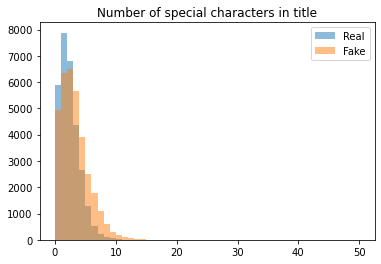

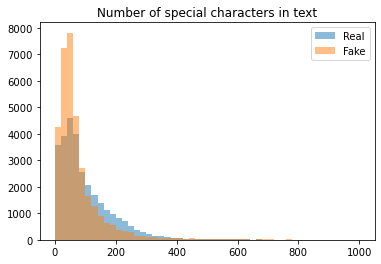

In [17]:
df['title_noise'] = df.title.str.count('[^\s\w]')
df['text_noise'] = df.text.str.count('[^\s\w]')

plt.hist(df[df.label==0].title_noise, alpha=0.5, range=(0,50), bins=50)
plt.hist(df[df.label==1].title_noise, alpha=0.5, range=(0,50), bins=50)
plt.title("Number of special characters in title")

plt.legend(['Real','Fake']) 
plt.show()

plt.hist(df[df.label==0].text_noise, alpha=0.5, range=(0,1000), bins=50)
plt.hist(df[df.label==1].text_noise, alpha=0.5, range=(0,1000), bins=50)
plt.title("Number of special characters in text")

plt.legend(['Real','Fake']) 
plt.show()

### Observation
- Fake news have more special characters in title, less in text compare to real news, however, with thicker tail.

In [18]:
def print_sentences_with_this_string(this_string, column_to_look, df_list, df_names, 
                                     print_words=False, print_set=False, sent_token=False):
    
    n_dataFrame = len(df_list)
    
    pat = re.compile(this_string)
    
    set_list = []
    
    for i in range(n_dataFrame):
        df = df_list[i]
        df = df[df[column_to_look].str.contains(this_string, regex= True, na=False)]
        
        count = df[column_to_look].count()
        
        
        print(this_string,'in',column_to_look,'\n',df_names[i],':',count)
        
        if count==0:
            continue
        
        
        if print_set:
            df = df.sample(min(len(df),1000), random_state=20)
        else:
            df = df.sample(min(len(df),20), random_state=20)
        
        corpus_list = df[column_to_look].to_numpy()
        index_list  = df.index.to_numpy()
                
        example_df = pd.DataFrame(columns=['index','selected_text','selected_words'])
        
      
        for row in range(len(index_list)):
            
            if sent_token:
                sentences = sent_tokenize(corpus_list[row])
            
                display_text = ''
                display_word = []
            
                for sentence in sentences:
                
                    if pat.search(sentence):
                        display_text += sentence+' '
                        display_word += pat.findall(sentence)
                                        
                example_df.loc[row] = [index_list[row],display_text,display_word]
            else:
                if pat.search(corpus_list[row]):
               
                    display_text = corpus_list[row]
                    display_word = pat.findall(display_text)
                    example_df.loc[row] = [index_list[row],display_text,display_word]
                
            
            
        example_df.set_index('index')
        
        if print_set:    
            #word_set = set()
            word_set = list()
            
            lst_list = list(example_df.selected_words)
            
            for lst in lst_list:
                word_set += lst
                
            #print(word_set)
            
            word_counter = Counter(word_set)
            print(word_counter.most_common(200))
        

        if not print_words:
            example_df.drop(['selected_words'], axis=1, inplace=True)


        
        display(example_df.sample(min(len(df),10), random_state=20))
        
        if print_set:
            set_list.append(word_set)
            
    #if print_set:
        #return set_list

In [19]:
# Check some abbreviation, and special characters
print_sentences_with_this_string('[\w]+[\.][\w]+',        
                                 'title', [df], ['All'], print_words=True, print_set=True)

print_sentences_with_this_string('[\w]+[\.][\w]+[\.][\w]+',        
                                 'title', [df], ['All'], print_words=True, print_set=True)

print_sentences_with_this_string('[A-Z][\w][\.] ',        
                                 'title', [df], ['All'], print_words=True, print_set=True)

print_sentences_with_this_string('[A-Z][\w][\w]+[\.] ',        
                                 'title', [df], ['All'], print_words=True, print_set=True)

print_sentences_with_this_string('[^\s]*[\@]+[^\s]*',        
                                 'text', [df], ['All'], print_words=True, print_set=True)

print_sentences_with_this_string('[^\s]*[\*]+[^\s]*',        
                                 'text', [df], ['All'], print_words=True, print_set=True)

print_sentences_with_this_string('[^\s]*//[^\s]+[.][^\s]+',        
                                 'text', [df], ['All'], print_words=True, print_set=True)

[\w]+[\.][\w]+ in title 
 All : 5472
[('U.S', 768), ('U.N', 70), ('D.C', 16), ('G.O', 14), ('F.B', 7), ('p.m', 6), ('N.C', 5), ('N.B', 4), ('P.M', 4), ('2.0', 4), ('C.I', 4), ('S.E', 4), ('1.5', 4), ('N.H', 3), ('5.4', 3), ('N.F', 3), ('1.4', 3), ('C.K', 2), ('1.1', 2), ('A.A', 2), ('A.I', 2), ('C.U', 2), ('5.7', 2), ('4.8', 2), ('V.P', 2), ('E.P', 2), ('3.5', 2), ('EE.UU', 2), ('4.5', 2), ('N.J', 2), ('H.R', 2), ('A.D', 2), ('H.D', 2), ('1.8', 2), ('W.H', 2), ('100percentfedUp.com', 2), ('U.K', 2), ('O.K', 2), ('Politics.com', 2), ('N.Y', 1), ('E.U', 1), ('C.E', 1), ('O.s', 1), ('21WIRE.TV', 1), ('I.C', 1), ('2.5', 1), ('5.23', 1), ('16.8', 1), ('D.L', 1), ('Wundergroundmusic.com', 1), ('kuebiko.co', 1), ('Report.com', 1), ('D.N', 1), ('3.6', 1), ('DavidWolfe.com', 1), ('F.D', 1), ('CounterCurrents.org', 1), ('2.8', 1), ('4.99', 1), ('27.5', 1), ('L.L', 1), ('2.9', 1), ('moralmatters.org', 1), ('99.99', 1), ('L.A', 1), ('122.5', 1), ('618.7', 1), ('Motivate3.com', 1), ('twitchy.com', 

,index,selected_text,selected_words
890,26937,U.S. renews call for Cambodia to release opposition leader from prison,[U.S]
694,20687,Trump confirms he is considering Mattis for U.S. defense post,[U.S]
798,7607,U.S. weighs calling Myanmar's Rohingya crisis 'ethnic cleansing',[U.S]
147,38327,Top U.S. Senate Democrat wants probe into details surrounding Flynn resignation,[U.S]
858,62838,COMMANDER IN CHIEF APPROVED RACISM? U.S. Military Makes SHOCKING Disciplinary Decision For 16 Black West Point Cadets,[U.S]
446,16498,The Big Question for the U.S. Economy: How Much Room Is There to Grow? - The New York Times,[U.S]
634,784,The U.S. government’s predatory-lending program,[U.S]
127,56326,WATCH: Hundreds of ILLEGAL ALIENS Storm Senate Building DEMANDING Citizenship…Where The Heck Is I.C.E.?,[I.C]
812,1255,Lawmaker says U.S. foreign surveillance 'unmasked' Trump associates,[U.S]
438,31259,U.S. business wary of skin-deep results from Trump-Xi trade talks,[U.S]


[\w]+[\.][\w]+[\.][\w]+ in title 
 All : 311
[('G.O.P', 80), ('F.B.I', 32), ('N.F.L', 23), ('U.S.A', 17), ('C.I.A', 17), ('E.P.A', 9), ('N.B.A', 9), ('S.N.L', 9), ('N.C.A', 9), ('F.D.A', 8), ('R.N.C', 4), ('A.D.H', 4), ('C.D.C', 4), ('D.N.C', 4), ('N.S.A', 3), ('C.E.O', 3), ('T.S.A', 3), ('F.C.C', 3), ('S.E.C', 3), ('H.I.V', 3), ('C.U.B', 2), ('A.N.C', 2), ('I.P.O', 2), ('Oct.26.2016', 2), ('M.T.A', 2), ('N.Y.U', 2), ('A.T.F', 2), ('I.R.A', 2), ('P.K.Subban', 2), ('A.C.L', 2), ('U.S.Has', 2), ('I.C.E', 2), ('A.I.G', 2), ('F.A.A', 2), ('L.G.B', 2), ('I.M.F', 2), ('L.I.R', 2), ('W.H.O', 2), ('Oct.30.2016', 1), ('childreninshadow.wordpress.com', 1), ('M.I.A', 1), ('N.I.H', 1), ('M.I.T', 1), ('I.O.C', 1), ('E.C.B', 1), ('U.F.C', 1), ('31.10.2016', 1), ('U.S.G', 1), ('B.O.B', 1), ('D.M.V', 1), ('P.G.A', 1), ('B.J.P', 1), ('K.G.B', 1), ('M.S.F', 1), ('N.E.A', 1), ('N.E.H', 1), ('U.C.L', 1), ('J.F.K', 1), ('U.N.C', 1), ('A.C.C', 1), ('F.T.C', 1), ('N.R.A', 1), ('M.L.B', 1), ('N.W.A', 1), ('N.

,index,selected_text,selected_words
62,27576,"Martin McGuinness, an I.R.A. Leader Turned Peacemaker, Dies at 66 - The New York Times",[I.R.A]
172,16842,Katie Rich of ‘S.N.L.’ Is Suspended for Tweet Mocking Barron Trump - The New York Times,[S.N.L]
208,10014,"Gorsuch, Russia, N.C.A.A. Final: Your Monday Evening Briefing - The New York Times",[N.C.A]
289,29746,Prisons Run by C.E.O.s? Privatization Under Trump Could Carry a Heavy Price - The New York Times,[C.E.O]
252,26135,One Dead and 3 Hurt After Off-Duty Officer’s S.U.V. Hits Pedestrians in Brooklyn - The New York Times,[S.U.V]
112,62905,Trump and G.O.P. Work to Win Repeal of Obama’s Health Act - The New York Times,[G.O.P]
170,8311,YOU WON’T BELIEVE Why Students In Communist Wisconsin Are No Longer Allowed To Chant “U.S.A.” At Sporting Events [VIDEO],[U.S.A]
81,50513,“GOOD-BYE SWEDEN”: How Muslim Violence…Porous Borders And Horrible Health Care Drove Swedish Blogger To U.S.A.,[U.S.A]
166,8930,Doctors With Enemies: Did Afghan Forces Target the M.S.F. Hospital? - The New York Times,[M.S.F]
300,61727,Think the N.C.A.A. Bracket’s Too Easy? Try One of These Pools - The New York Times,[N.C.A]


[A-Z][\w][\.]  in title 
 All : 414
[('Dr. ', 87), ('Jr. ', 80), ('St. ', 48), ('Mr. ', 38), ('No. ', 36), ('It. ', 14), ('JR. ', 13), ('Vs. ', 11), ('Ft. ', 9), ('Yr. ', 8), ('Lt. ', 8), ('DR. ', 6), ('MR. ', 6), ('Up. ', 5), ('Co. ', 5), ('Sr. ', 4), ('PT. ', 4), ('In. ', 3), ('Ms. ', 3), ('EC. ', 3), ('Pa. ', 3), ('VS. ', 3), ('Rs. ', 2), ('LA. ', 2), ('CO. ', 2), ('EP. ', 2), ('Va. ', 2), ('UK. ', 2), ('LT. ', 2), ('UU. ', 2), ('OV. ', 2), ('Fr. ', 2), ('Ep. ', 2), ('Ky. ', 2), ('LK. ', 2), ('ED. ', 1), ('By. ', 1), ('TV. ', 1), ('FO. ', 1), ('Fl. ', 1), ('PD. ', 1), ('II. ', 1), ('OP. ', 1), ('NA. ', 1)]


,index,selected_text,selected_words
362,60082,WOW! VIDEO CAPTURES Angry St. Louis Protesters Turning On Media…TV Reporter Calls Unprovoked Attack: “The Scariest Moment Of My Career”,[St. ]
174,62001,Peter Doig Says He Didn’t Paint This. Now He Has to Prove It. - The New York Times,[It. ]
13,5745,Trump St. Patrick’s Day Hats Disappear After Shamrock Mix-Up - The New York Times,[St. ]
121,4806,SOME FLA. RESIDENTS PLAN ARMED TRICK-OR-TREATING AFTER CREEPY CLOWN THREATS,[LA. ]
129,4955,“ENTITLED” DEM REP. SHEILA JACKSON LEE Has Been Taking Advantage Of Her “Public Servant” Status On Airplanes For Decades: “Don’t you know who I am?…Where is my seafood meal?”,[EP. ]
267,10154,Ep. 544 FADE to BLACK Jimmy Church w/ Laura Eisenhower : Restoring the Balance [VIDEO],[Ep. ]
277,25175,Lavrov says wild that Trump Jr. blamed for meeting Russian lawyer,[Jr. ]
247,10715,Senate's No. 2 Republican eyes healthcare vote next week: The Hill,[No. ]
131,17805,"Shoes, Shirts, You Name It, College Basketball Players Get It. Free. - The New York Times",[It. ]
332,22742,Racist Far-Right Media BLASTS CNN On Ft. Lauderdale Shooter And Royally F*cks Up (IMAGES),[Ft. ]


[A-Z][\w][\w]+[\.]  in title 
 All : 793
[('Rep. ', 115), ('Gov. ', 53), ('Dept. ', 51), ('Sen. ', 47), ('Feb. ', 18), ('Trump. ', 17), ('Nov. ', 17), ('Oct. ', 16), ('Dec. ', 13), ('Jan. ', 11), ('Gen. ', 10), ('Fmr. ', 9), ('Mrs. ', 8), ('Pres. ', 7), ('Sept. ', 7), ('Sec. ', 6), ('Dem. ', 6), ('Again. ', 6), ('Corp. ', 5), ('Prof. ', 5), ('Clinton. ', 5), ('Out. ', 4), ('DEPT. ', 4), ('Vol. ', 4), ('Admin. ', 4), ('Too. ', 4), ('Hillary. ', 4), ('Life. ', 3), ('Chance. ', 3), ('Problem. ', 3), ('Election. ', 3), ('Why. ', 3), ('Family. ', 3), ('Bros. ', 3), ('Back. ', 3), ('Calif. ', 3), ('Cong. ', 3), ('Right. ', 3), ('Moscow. ', 3), ('Fla. ', 3), ('America. ', 3), ('One. ', 3), ('Time. ', 3), ('Work. ', 3), ('SEC. ', 3), ('Days. ', 3), ('Reps. ', 3), ('FLA. ', 2), ('Americans. ', 2), ('Col. ', 2), ('Win. ', 2), ('Plan. ', 2), ('Space. ', 2), ('Warming. ', 2), ('Politics. ', 2), ('Man. ', 2), ('Star. ', 2), ('Obamacare. ', 2), ('Facts. ', 2), ('Over. ', 2), ('Univ. ', 2), ('Wrong. 

,index,selected_text,selected_words
694,51645,Belgian judge to decide on warrant for ex-Catalan leader on Dec. 14: lawyer,[Dec. ]
20,10286,Clickventure: You Were Abducted By Aliens. Will Anyone Ever Believe You?,[Aliens. ]
501,56720,Tillerson Leads From State Dept. Shadows as White House Steps In - The New York Times,[Dept. ]
596,20204,"Irony: Mike Pence Shames Pres. Obama For Name Calling – No, Really",[Pres. ]
788,18628,Fmr. Bush 41 Adviser DESTROYS ‘Massively Ignorant’ Donald Trump (VIDEO),[Fmr. ]
642,26349,CRITICALLY WOUNDED GOP Rep. Steve Scalise Stood By Trump When Others Deserted Him…Recently Made Adorable Birthday Video Message With Trump For His Daughter [VIDEO],[Rep. ]
526,21961,Matt Bevin is the next governor of Kentucky. He has President Obama to thank.,[Kentucky. ]
387,22127,I Thought I Understood the American Right. Trump Proved Me Wrong. - The New York Times,"[Right. , Wrong. ]"
484,58084,One Family. Six Decades. Myriad Views of Fidel Castro’s Revolution. - The New York Times,"[Family. , Decades. , Revolution. ]"
90,69105,Dr. David Duke and Prof. Kevin MacDonald on Duke’s overwhelming victory in the debate,[Prof. ]


[^\s]*[\@]+[^\s]* in text 
 All : 10512
[('(@realDonaldTrump)', 166), ('@realDonaldTrump', 83), ('2017@realDonaldTrump', 54), ('@21WIRE.TV', 41), ('@', 27), ('@pamkeyNEN', 22), ('@POTUS', 21), ('(@FoxNews)', 20), ('(@JYSexton)', 20), ('2016@realDonaldTrump', 20), ('@IanHanchett', 18), ('(@laurenduca)', 18), ('2017.@realDonaldTrump', 17), ('briefing@nytimes.', 15), ('@nytimes', 15), ('@jeff_poor', 14), ('@dznussbaum', 12), ('(@PrisonPlanet)', 11), ('(@atensnut)', 11), ('@AWRHawkins.', 10), ('awrhawkins@breitbart.', 10), ('@warnerthuston', 10), ('igcolonel@hotmail.', 10), ('(@joshdcaplan)', 10), ('@HillaryClinton', 10), ('@megynkelly', 10), ('(@wikileaks)', 10), ('2017@SarahPalinUSA', 10), ('(@clmazin)', 10), ('(@TheRickWilson)', 10), ('@joelpollak.', 9), ('@SarahPalinUSA', 9), ('(@HillaryClinton)', 9), ('@MrNashington', 9), ('(@es_snipes)', 9), ('(@tonyposnanski)', 8), ('@POTUS.', 8), ('(@TomFitton)', 8), ('(@RealJamesWoods)', 8), ('MEMBER@', 8), ('@BobPriceBBTX', 8), ('@AaronKleinShow.

,index,selected_text,selected_words
890,16383,Sen. John McCain (R-Ariz) went full-Maverick during an emotional speech Monday night after receiving the National Constitution Center s Liberty Medal. McCain appeared to target Donald Trump and hi...,"[@ChrisPlanteShow:, (@stevenportnoy), (@danmericaCNN)]"
694,10289,"America Has Become A Lawless Nation – Hillary Clinton Magically Cleared By The FBI By Michael Snyder, on July 5th, 2016 \nIt is hard to be proud to be an American today after watching FBI director...",[f$&@er]
798,18500,Daniel Greenfield s take on why Obama spied on Trump is the best yet. He takes you through the twists and turns to expose Obama and his cronies for the liars and cheats they are. We d love to know...,[(@CNN)]
147,19607,"Twitter s pitch deck for RT?21st Century Wire says In what appears to be a coordinated attack on RT and Sputnik, Twitter CEO Jack Dorsey (@jack) has declared all advertising purchased by the two ...","[(@jack), (@jack), @jack, @congressdotgov, @Twitter, @RT_com, (@M_Simonyan), @21WIRE.TV]"
858,32604,Mark Levin dropped a bombshell on his show tonight about the Muslim terrorist who killed 9 people in Manhattan and injured dozens. The Diversity VISA program was given the green light by none oth...,"[(@MDDeplorable), (@WayneSense)]"
446,6582,"In a video message to young Catholics throughout the world, Pope Francis proposed the Virgin Mary as a model of active Christian discipleship, noting that she was no passive “couch potato. ”[The V...",[@tdwilliamsrome]
634,23952,Do you see it? Right below the word birthday you ll see a tiny spot. People really need something to do because social media has been on fire with questions about what the small mark means as if...,"[(@FLOTUS), (@sarahjeong)]"
127,20052,"Here s a new low for America: During the unfolding tragedy in England, NBC announced that it would not be displaying the messages of Donald Trump, the President of the United States, because his t...","[(@NBCNightlyNews), (@kbeninato)]"
812,41006,"Patrick Henningsen 21st Century WireAny business expert will tell you that marketing is not an exact science. The same is true in politics, and even more so in this historic election season. As th...","[(@StopTrumpPAC), (@ByronYork), @marcorubio, (@TeamMarco)]"
438,57239,21st Century Wire says The investigation team at Project Veritas just released the first part in another hidden camera interview series which apparently documents their undercover journalist speak...,[@21WIRE.TV]


[^\s]*[\*]+[^\s]* in text 
 All : 2521
[('*', 866), ('f*ck', 83), ('f*cking', 83), ('**', 77), ('sh*t', 65), ('***', 60), ('****', 37), ('F*ck', 30), ('f**king', 28), ('f**k', 23), ('*NOTE:', 21), ('F**k', 20), ('*The', 19), ('a**', 19), ('bullsh*t', 17), ('f***ing', 14), ('sh*t.', 13), ('f***', 12), ('f*cked', 11), ('p*ssy', 11), ('***Language', 10), ('bullsh*t.', 10), ('b*tch', 9), ('sh*t,', 9), ('**Want', 8), ('here.**', 8), ('a**hole', 8), ('***ALSO', 8), ('b*tch.', 8), ('s**t', 7), ('c*ck', 6), ('*In', 6), ('***KWN', 6), ('THEMES*', 6), ('n*gger,', 6), ('F***', 6), ('#^@&*!', 6), ('n****r', 5), ('f*cks', 5), ('f***ed', 5), ('President*', 5), ('THEMES*Download', 5), ('n*gger', 5), ('THEMES*Listen', 5), ('*president', 5), ('p*ssy.', 5), ('THEMES*Direct', 5), ('batsh*t', 4), ('sh*tty', 4), ('Amazon.com.*', 4), ('*gasp*', 4), ('s**t.', 4), ('c*nt', 4), ('s***', 4), ('“F*ck', 4), ('G*damn', 4), ('***WARNING***', 4), ('*UPDATE*', 4), ('Muse*', 3), ('n*gger.', 3), ('*Back', 3), ('sh*t-st

,index,selected_text,selected_words
890,4916,WASHINGTON (Reuters) - U.S. conservative activist Phyllis Schlafly died on Monday at 92. Following are some facts about her: * Schlafly said she tirelessly fought against the proposed Equal Right...,"[*, *, *, *, *, *]"
694,26423,"They were probably just looking for a safe space to study Protesters at Dartmouth University disrupted students studying in the library, reportedly directing profanity towards white students and...","[F*ck, F*ck]"
798,70779,"Clinton Campaign Circulated Paul Ryan Relative as Possible Supreme Court Pick Another reason as to why Ryan tried to sabotage Trump's campaign? Paul Joseph Watson - October 27, 2016 Comments Hilla...","[*twice*., *The, Wire*)]"
147,28361,"After the teeny-tiny tenure of Anthony (the Mooch) Scaramucci, the gates of hell have opened. Now that we ve had a foul-mouthed Sopranos extra leading the communications team (even if ever so brie...",[*um*]
858,25756,"Larry Wilmore used the n-word on Saturday night to cap off his bit at the White House Correspondents Dinner to congratulate President Obama, and that made one Fox host incredibly jealous. Yo Barr...","[n***a,]"
446,14173,"Meet James Stachowiak. If he looks familiar, you may remember him as the guy who made headlines for telling his fellow patriots to shoot black women and children in the heads if they were seen s...",[f*ck]
634,53626,"Asking thug, Michael Brown s mom to speak at the DNC is a new low even for Hillary. If the DNC had to have a black mother speak in order to pander to a certain demographic, couldn t they have foun...",[b*tch]
127,26655,"Donald Trump s administration is already proving to be a complete and utter sh*tshow, but did you know his Twitter security is just as bad as his leadership? The Intercept reports that Donald Trum...","[sh*tshow,, vi***************@gmail.com,]"
812,48265,"After working for months to build a solid white supremacist base, Donald Trump suddenly started focusing on minority outreach last week. But CNN commentator and New York Times columnist Charles ...",[bullsh*t]
438,41136,She explains : \nHillary Clinton wants to start an air war with Russia. Let’s be clear: That’s what a no-fly zone means. It is tantamount to a declaration of war against Russia. \n\n*** \n\nClearl...,"[***, ***, ***, ***, ***]"


[^\s]*//[^\s]+[.][^\s]+ in text 
 All : 4338
[('http://www.infowarsstore.com/health-and-wellness/infowars-life/brain-force.html?ims=tzrwu&utm_campaign=Infowars+Placement&utm_source=Infowars.com&utm_medium=Widget&utm_content=Brain+Force', 72), ('http://www.infowars.com/wp-content/uploads/2015/10/brainforce-25-200-e1476824046577.jpg', 36), ('"//connect.facebook.net/en_US/sdk.js#xfbml=1&#038;version=v2.3";', 19), ("href=''http://link-address.com''>Name", 9), ('https://facebook.com/LukeWeAreChange', 8), ('https://twitter.com/Lukewearechange', 8), ('http://instagram.com/lukewearechange', 8), ('http://ruptly.tv', 6), ('"//connect.facebook.net/en_US/sdk.js#xfbml=1&version=v2.3";', 6), ('https://t.co/6OZtrfIwim', 5), ('https://t.co/4nxLipafWO', 4), ('https://t.co/ifeSBlSZW7', 4), ('http://www.youtube.com/subscription_c…', 4), ('http://wearechange.org/', 4), ('https://www.patreon.com/WeAreChange?a…', 4), ('http://wearechange.org/store', 4), ('http://wearechange.org/donate', 4), ('https://t.co/T

,index,selected_text,selected_words
890,65897,"Fox News host Sean Hannity flew into a two-day rage desperately trying to defend Donald Trump.As revealed on Friday, Trump said some very vulgar and indefensible things about women in 2005 during ...","[https://t.co/dw6RRS4zE8, https://t.co/IfK1tUwAiX, https://t.co/YWgQQ12lhG, https://t.co/t7lOLMMh2S, https://t.co/pANnv2qP1N, https://t.co/COXXSWQRRM, https://t.co/PdOj5esDzW, https://t.co/bO45R4a..."
694,332,LET S FACE IT EUROPE IS TOAST! HERE S A MUSLIM IMAM SPILLING THE BEANS ON THE HIJRAH: WE WILL CONQUER THEIR COUNTRIES https://www.youtube.com/watch?v=OLE1pXGo700It s difficult to see this screens...,[https://www.youtube.com/watch?v=OLE1pXGo700It]
798,65109,Former acting Attorney General Sally Yates was grilled about her refusal to defend the president s travel executive order She made huge mistake by assuming what Trump said during the campaign coul...,[States.https://www.youtube.com/watch?v=nGqsrx0LpTcHere]
147,69828,"New Black Panther Entertainer of The Year, Beyonce showed up at the White House dressed like a two-bit hooker for the annual Easter Egg Roll. I suppose it s a better choice than her militant, bull...","[blazer.https://twitter.com/BeyonceNation4/status/714499038926802945But, https://t.co/7Ee64HKI2S]"
858,53629,"I want everybody to know that we stand behind Donald J. Trump! (function(d, s, id) { var js, fjs = d.getElementsByTagName(s)[0]; if (d.getElementById(id)) return; js = d.createElement(s); js.i...","[""//connect.facebook.net/en_GB/sdk.js#xfbml=1&version=v2.3"";]"
446,51897,Mexico has been the beneficiary of our open borders for decades. It s really quite amazing how loudly they cry foul when we finally have a presidential candidate willing to stand up to this insani...,[wire.https://youtu.be/V48ttgGqsswIt]
634,16194,"When news of the death of former First Lady Nancy Reagan came through on Sunday, the majority of liberals and conservatives put aside their differences to send condolences to the family and reflec...",[https://t.co/GPNI7EbqBs]
127,14198,"Conservative Hollywood actor, James Woods, is known for his brilliant wit and his great sense of humor on Twitter, but today he really outdid himself when he posted two hilarious videos on Twitter...","[https://t.co/afHPsh9flM, https://t.co/Y07Q0Rmcw6]"
812,15272,"Alleged President Donald Trump created worldwide chaos with his latest executive order banning Muslims from entering the U.S. Yes, it is a Muslim ban. I ll tell you the whole history of it, Giul...","[https://t.co/snpcZJuU2k, https://t.co/tLSoAhgh7g, https://t.co/aX7GXzLwZj, https://t.co/CnZtrN2sgy, https://t.co/snpcZJuU2k]"
438,9747,"JUDGE NEIL GORSUCH A strict conservative similar to Justice Scalia A STRICT CONSTITUTIONALISTJudge Neil Gorsuch, 49, is President Donald Trump s pick for appointment to the Supreme Court to fi...","[https://t.co/D91eYAcIMZ, https://t.co/dbCiP2bP2U]"


### Observation
- **U.S.  or U.S.A.**: variation of the United States, comes from fake news or typo. 
- Some abbreviation might affect on tokenization, but it will take infinite time to perfectly handle it.
- Words with \@ and website address should be replaced.

# Conclusion
Those findings will be applied at data cleaning and text preprocessing in the next step.